In [17]:
from pyshtools import legendre as pleg
from scipy.integrate import simps
import matplotlib.pyplot as plt
from math import sqrt, pi
import numpy as np
import time
%matplotlib notebook

### Functions involving Legendre polynomials
- get_pleg_index (gets the index of legpoly)
- gen_leg (Generates the legendre polynomials)
- hor_div (Get horizontal divergence of the given vector field)

In [22]:
def get_pleg_index(l, m):
    return int( l*(l+1)/2 + m )

def gen_leg(lmax, theta):
    cost = np.cos(theta)
    sint = np.sin(theta)
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    leg = np.zeros( ( maxIndex, theta.size ) )
    leg_d1 = np.zeros( ( maxIndex, theta.size ) )
    dp_leg = np.zeros( (maxIndex, theta.size), dtype=complex)

    count = 0
    for z in cost:
        leg[:, count], leg_d1[:, count] = pleg.PlmBar_d1(lmax, z, 1, 1)
        count += 1
    dt_leg = leg_d1 * (-sint).reshape(1, sint.shape[0])
    
    ellArr = np.zeros(maxIndex)
    emmArr = np.zeros(maxIndex)
    countm, countl = 0, 0
    for i in range(maxIndex):
        ellArr[i] = countl
        emmArr[i] = countm
        if countm==countl:
            countl += 1
            countm = 0
        else:
            countm += 1
    norm = np.sqrt( ellArr * (ellArr + 1) )
    norm[norm<1] = 1.0
    
    legtemp = leg.copy()
    dp_leg = 1j*emmArr.reshape(maxIndex, 1) * legtemp / sint.reshape(1, sint.shape[0])
    dt_leg /= norm.reshape(maxIndex, 1)
    dp_leg /= norm.reshape(maxIndex, 1)
    return leg/sqrt(2)/sqrt(2*pi), dt_leg/sqrt(2)/sqrt(2*pi), dp_leg/sqrt(2)/sqrt(2*pi)

def gen_leg_real(lmax, theta):
    cost = np.cos(theta)
    sint = np.sin(theta)
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    leg = np.zeros( ( maxIndex, theta.size ) )
    leg_d1 = np.zeros( ( maxIndex, theta.size ) )
    dp_leg = np.zeros( (maxIndex, theta.size) )

    count = 0
    for z in cost:
        leg[:, count], leg_d1[:, count] = pleg.PlmBar_d1(lmax, z, 1, 1)
        count += 1
    dt_leg = leg_d1 * (-sint).reshape(1, sint.shape[0])
    
    ellArr = np.zeros(maxIndex)
    emmArr = np.zeros(maxIndex)
    countm, countl = 0, 0
    for i in range(maxIndex):
        ellArr[i] = countl
        emmArr[i] = countm
        if countm==countl:
            countl += 1
            countm = 0
        else:
            countm += 1
    norm = np.sqrt( ellArr * (ellArr + 1) )
    norm[norm<1] = 1.0
    
    legtemp = leg.copy()
    dp_leg = emmArr.reshape(maxIndex, 1) * legtemp / sint.reshape(1, sint.shape[0])
    dt_leg /= norm.reshape(maxIndex, 1)
    dp_leg /= norm.reshape(maxIndex, 1)
    return leg/sqrt(2)/sqrt(2*pi), dt_leg/sqrt(2)/sqrt(2*pi), dp_leg/sqrt(2)/sqrt(2*pi)

def hor_div(ut, up, theta, phi):
    dth = theta[1] - theta[0]
    dph = phi[1] - phi[0]
    dt_ut = (ut[1:, :] - ut[:-1, :])/dth
    dp_up = (up[:, 1:] - up[:, :-1])/dph
    return dt_ut[:, :-1] + dp_up[:-1, :]

### Back and forth between frequency space and real space
- vel_from_spectra (computes ur, ut, up from ulm, vlm, wlm)
- compute_los_spectra (computes ulm, vlm, wlm using los data)
- compute_full_spectra (computes ulm, vlm, wlm using ur, ut, up)
- vel_spectra (calls both compute_los_spectra and compute_full_spectra) 
- gen_full_mat3 (Generates the leakage matrix)
- inv_SVD (computes inverse using SVD)
- inv_reg1 ( computes inverse using regularization)

In [24]:
def vel_from_spectra(ulm, vlm, wlm, thSize, phSize, lmax, t):
    theta = np.linspace(1e-5, pi-1e-5, thSize)
    phi = np.linspace(1e-5, 2*pi - 1e-5, phSize)
    cost = np.cos(theta)
    sint = np.sin(theta)
    
    leg, dt_leg, dp_leg = gen_leg(lmax, theta); leg1 = leg.copy()
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    
    ur = np.zeros( (thSize, phSize), dtype=complex)
    ut = np.zeros( (thSize, phSize), dtype=complex)
    up = np.zeros( (thSize, phSize), dtype=complex)
    
    countt, countm, countl = 0, 0, 0
    for i in range(maxIndex):
        if countm==t:
            costp = np.cos(t*phi)
            sintp = np.sin(t*phi)
            eitp = (costp + 1j*sintp).reshape(1, phSize)
            
            ur += ulm[countt] * leg[i, :].reshape(thSize, 1) * eitp
            
            ut += vlm[countt] * dt_leg[i, :].reshape(thSize, 1) * eitp
            ut -= wlm[countt] * dp_leg[i, :].reshape(thSize, 1) * eitp 
            
            up += vlm[countt] * dp_leg[i, :].reshape(thSize, 1) * eitp
            up += wlm[countt] * dt_leg[i, :].reshape(thSize, 1) * eitp 
            
            countt += 1
        if countm==countl:
            countm = 0
            countl += 1
        else:
            countm += 1
    return ur, ut, up

def minus1pow(k):
    if abs(k)%2==0:
        return 1
    else:
        return -1

def compute_los_spectra(lmax, t, fr, ft, fp, theta, phi):
    maxLen = lmax + 1 - t
    thSize = theta.shape[0]
    phSize = phi.shape[1]
    leg, dt_leg, dp_leg = gen_leg(lmax, theta)
    
    # reshaping for multiplication during integration
    sint = np.sin(theta).reshape(thSize, 1)
    cost = np.cos(theta).reshape(thSize, 1)
    lr, lt, lp = cost, -sint, 0.0*sint
    
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    ulm = np.zeros(maxLen, dtype=complex)
    vlm = np.zeros(maxLen, dtype=complex)
    wlm = np.zeros(maxLen, dtype=complex)
    
    countm, countl, countInd = 0, 0, 0
    costp = np.cos(t*phi)
    sintp = np.sin(t*phi)
    eitp = (costp - 1j*sintp).flatten()
    for ell in range(t, maxLen+1):
        i = int(get_pleg_index(ell, t))
        ulm[countInd] = simps( simps( leg[i, :].conjugate().reshape(thSize, 1) *\
                                     fr * sint, x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        vlm[countInd] = simps( simps( dt_leg[i, :].conjugate().reshape(thSize, 1) * ft * sint + \
                    dp_leg[i, :].conjugate().reshape(thSize, 1) * fp * sint, x=theta.flatten(), axis=0) * eitp, x=phi.flatten()) 
        wlm[countInd] = simps( simps( - dp_leg[i, :].conjugate().reshape(thSize, 1) * ft * sint + \
                    dt_leg[i, :].conjugate().reshape(thSize, 1) * fp * sint, x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        countInd += 1
    return ulm, vlm, wlm

def compute_full_spectra(lmax, t, ur, ut, up, theta, phi):
    maxLen = lmax + 1 - t
    thSize = theta.shape[0]
    phSize = phi.shape[1]
    leg, dt_leg, dp_leg = gen_leg(lmax, theta)
    
    sint = np.sin(theta).reshape(thSize, 1)
    cost = np.cos(theta).reshape(thSize, 1)
    lr, lt, lp = cost, -sint, 0.0*sint
    
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    ulm = np.zeros(maxLen, dtype=complex)
    vlm = np.zeros(maxLen, dtype=complex)
    wlm = np.zeros(maxLen, dtype=complex)
    
    countm, countl, countInd = 0, 0, 0
    costp = np.cos(t*phi)
    sintp = np.sin(t*phi)
    eitp = (costp - 1j*sintp).flatten()
    for ell in range(t, maxLen+1):
        i = int(get_pleg_index(ell, t))
        ulm[countInd] = simps( simps( leg[i, :].conjugate().reshape(thSize, 1) * ur * sint,\
                                     x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        vlm[countInd] = simps( simps( dt_leg[i, :].conjugate().reshape(thSize, 1) * ut * sint + \
                                     dp_leg[i, :].conjugate().reshape(thSize, 1) * up * sint,\
                                     x=theta.flatten(), axis=0) * eitp, x=phi.flatten()) 
        wlm[countInd] = simps( simps( -dp_leg[i, :].conjugate().reshape(thSize, 1) * ut * sint + \
                                     dt_leg[i, :].conjugate().reshape(thSize, 1) * up * sint,\
                                     x=theta.flatten(), axis=0) * eitp, x=phi.flatten())
        countInd += 1
    return ulm, vlm, wlm

def vel_spectra(velField, thSize, minVal, lmax, t):
    thF = np.linspace(minVal, pi-minVal, 2*thSize).reshape(2*thSize, 1)
    th = thF[thF<pi/2].reshape(thSize, 1)
    ph = np.linspace(minVal, 2*pi-minVal, thSize).reshape(1, thSize)
    
    # computing coefficients of vector field
    velrF, veltF, velpF = velField
    """
    velrF= np.random.rand(2*thSize, thSize) - 0.5
    veltF = 10*(np.random.rand(2*thSize, thSize) - 0.5)* np.sin(thF)
    velpF = 100*(np.random.rand(2*thSize, thSize) - 0.5)* np.sin(thF)
    """
    
    # computing coefficients of the LOS field
    lr, lt, lp = np.cos(th), -np.sin(th), 0*np.cos(th)
    velr = velrF[:thSize, :]
    velt = veltF[:thSize, :]
    velp = velpF[:thSize, :]
    losvel = lr*velr + lt*velt + lp*velp
    fr, ft, fp = losvel*lr, losvel*lt, losvel*0.0
    
    ulmF, vlmF, wlmF = compute_full_spectra(lmax, t, velrF, veltF, velpF, thF, ph)
    ulm, vlm, wlm = compute_los_spectra(lmax, t, fr, ft, fp, th, ph)
    
    return ulm, vlm, wlm, ulmF, vlmF, wlmF

def gen_full_mat3(t, lmax, theta):
    sint = np.sin(theta)
    cost = np.cos(theta)
    
    lr = cost; lt = -sint;
    leg, dt_leg, dp_leg = gen_leg(lmax, theta)
    
    matsize = lmax + 1 - t
    fullMat = np.zeros((matsize*3, matsize*3), dtype=complex);
    
    for i in range(matsize*3):
        ui, ess = divmod(i, matsize)
        ess += t
        for j in range(matsize*3):
            uj, ell = divmod(j, matsize)
            ell += t
            normell = np.sqrt( ell * (ell + 1) ) if ell>0 else 1.0
            if ui==0 and uj==0:
                fullMat[i, j] = simps( sint * lr**2 * leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :].conjugate(), x=theta) 
            elif ui==0 and uj==1:
                fullMat[i, j] = simps( sint * lr*lt * leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :].conjugate(), x=theta) 
            elif ui==0 and uj==2:
                fullMat[i, j] = simps( sint * lr*lt * leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :].conjugate(), x=theta)
            elif ui==1 and uj==0:
                fullMat[i, j] = simps( sint * lr*lt * dt_leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :].conjugate(), x=theta) 
            elif ui==1 and uj==1:
                fullMat[i, j] = simps( sint * lt**2 * dt_leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :].conjugate(), x=theta) 
            elif ui==1 and uj==2:
                fullMat[i, j] = simps( sint * lt**2 * dt_leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :].conjugate(), x=theta)
            elif ui==2 and uj==0:
                fullMat[i, j] = simps( sint * lr*lt * dp_leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :].conjugate(), x=theta)
            elif ui==2 and uj==1:
                fullMat[i, j] = simps( sint * lt**2 * dp_leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :].conjugate(), x=theta)
            elif ui==2 and uj==2:
                fullMat[i, j] = simps( sint * lt**2 * dp_leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :].conjugate(), x=theta)
    return fullMat*2*pi

def gen_full_mat3_real(t, lmax, theta):
    sint = np.sin(theta)
    cost = np.cos(theta)
    
    lr = cost; lt = -sint;
    leg, dt_leg, dp_leg = gen_leg_real(lmax, theta)
    
    matsize = lmax + 1 - t
    fullMat = np.zeros((matsize*3, matsize*3));
    
    for i in range(matsize*3):
        ui, ess = divmod(i, matsize)
        ess += t
        for j in range(matsize*3):
            uj, ell = divmod(j, matsize)
            ell += t
            normell = np.sqrt( ell * (ell + 1) ) if ell>0 else 1.0
            if ui==0 and uj==0:
                fullMat[i, j] = simps( sint * lr**2 * leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :], x=theta) 
            elif ui==0 and uj==1:
                fullMat[i, j] = simps( sint * lr*lt * leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :], x=theta) 
            elif ui==0 and uj==2:
                fullMat[i, j] = -simps( sint * lr*lt * leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :], x=theta)
            elif ui==1 and uj==0:
                fullMat[i, j] = simps( sint * lr*lt * dt_leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :], x=theta) 
            elif ui==1 and uj==1:
                fullMat[i, j] = simps( sint * lt**2 * dt_leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :], x=theta) 
            elif ui==1 and uj==2:
                fullMat[i, j] = -simps( sint * lt**2 * dt_leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :], x=theta)
            elif ui==2 and uj==0:
                fullMat[i, j] = -simps( sint * lr*lt * dp_leg[get_pleg_index(ess, t), :]
                                     * leg[get_pleg_index(ell, t), :], x=theta)
            elif ui==2 and uj==1:
                fullMat[i, j] = -simps( sint * lt**2 * dp_leg[get_pleg_index(ess, t), :]
                                     * dt_leg[get_pleg_index(ell, t), :], x=theta)
            elif ui==2 and uj==2:
                fullMat[i, j] = simps( sint * lt**2 * dp_leg[get_pleg_index(ess, t), :]
                                     * dp_leg[get_pleg_index(ell, t), :], x=theta)
    return fullMat*2*pi

def inv_SVD(A, svdlim):
    u, s, v = np.linalg.svd(A, full_matrices=False)
    sinv = s**-1
#    '''
    plt.figure()
    plt.semilogy(sinv, '.')
    plt.axhline(y=svdlim)
    plt.title("Singular values")
    plt.show()
#    '''
    sinv[sinv/sinv[0] > svdlim] = 0.0#svdlim
    return np.dot( v.transpose().conjugate(), np.dot(np.diag(sinv), u.transpose().conjugate()))

def inv_reg1(A, regparam):
    Ashape = A.shape[0];
    return np.linalg.inv(A.transpose().conjugate().dot(A) + regparam * np.identity(Ashape)).dot(A.transpose().conjugate())

#### Input profile = random numbers in real space
- Create a random vector field on the surface of sphere. Compute $u_{lm}, v_{lm}, w_{lm}$ for the vector field $\vec{u}$. Also explicitly compute $\vec{l}\cdot\vec{u}$

/home/samarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/samarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>


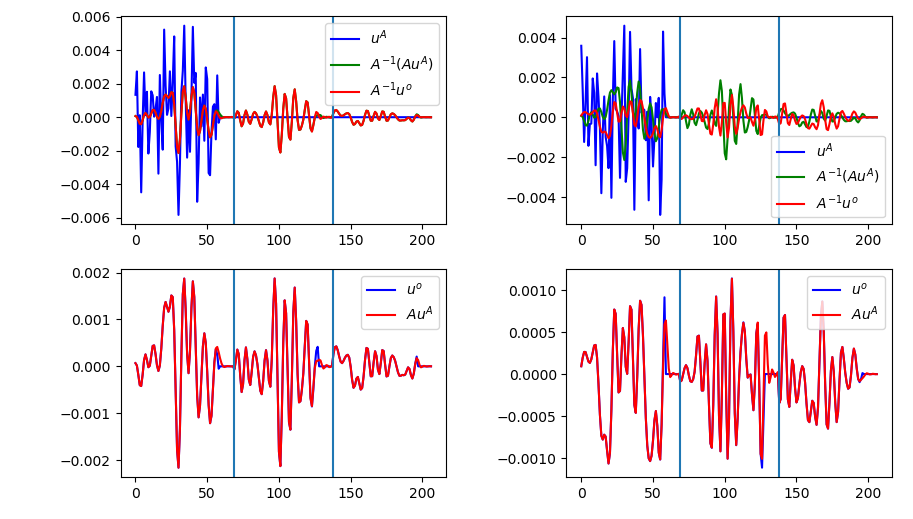

In [52]:
thSize = 200; lmax = 79; t = 11; maxSize = lmax + 1 - t
minVal = 1e-5
thF = np.linspace(minVal, pi-minVal, 2*thSize).reshape(2*thSize, 1)
theta = thF[thF<pi/2]
urIP = 1*(np.random.rand(2*thSize, thSize) - 0.5)
utIP = 0*(np.random.rand(2*thSize, thSize) - 0.5)* np.sin(thF)
upIP = 0*(np.random.rand(2*thSize, thSize) - 0.5)* np.sin(thF)
velIP = urIP, utIP, upIP

ulm, vlm, wlm, ulmA, vlmA, wlmA = vel_spectra(velIP, thSize, minVal, lmax, t)
uA = np.concatenate((ulmA, vlmA, wlmA), axis=0)
uop = np.concatenate((ulm, vlm, wlm), axis=0)
Afull = gen_full_mat3(t, lmax, theta)
np.savez_compressed("mat_new.npz", A=Afull, t=t, lmax=lmax, theta=theta)
uop2 = Afull.dot(uA.transpose()).transpose()
#uA = np.concatenate((ulmA*10, vlmA/2, wlmA/3), axis=0)
AinvFull = inv_reg1(Afull, 1e-2)
uInverted = AinvFull.dot(uop)
uInverted2 = AinvFull.dot(uop2)# * (1 + 0.05*np.random.rand())) 
diff = (uop2 - uop)/uop*100

plt.figure()
plt.subplot(221)
plt.plot((uA.real), 'b', label="$u^A$")
plt.plot((uInverted2.real), 'g', label="$A^{-1}( A u^A )$")
plt.plot(uInverted.real, 'r', label="$A^{-1} u^o$")
plt.axvline(x=maxSize)
plt.axvline(x=2*maxSize)
plt.legend()

plt.subplot(222)
plt.plot((uA.imag), 'b', label="$u^A$")
plt.plot((uInverted2.real), 'g', label="$A^{-1}( A u^A )$")
plt.plot(uInverted.imag, 'r', label="$A^{-1} u^o$")
plt.axvline(x=maxSize)
plt.axvline(x=2*maxSize)
plt.legend()


plt.subplot(223)
plt.plot(uop.real, 'b', label="$u^o$")
plt.plot(uop2.real, 'r', label="$Au^A$")
plt.axvline(x=maxSize)
plt.axvline(x=2*maxSize)
plt.legend()

plt.subplot(224)
plt.plot(uop.imag, 'b', label="$u^o$")
plt.plot(uop2.imag, 'r', label="$Au^A$")
plt.axvline(x=maxSize)
plt.axvline(x=2*maxSize)
plt.legend()

plt.tight_layout()
plt.show()

#plt.figure()
#plt.plot(diff)
#plt.show()

<IPython.core.display.Javascript object>


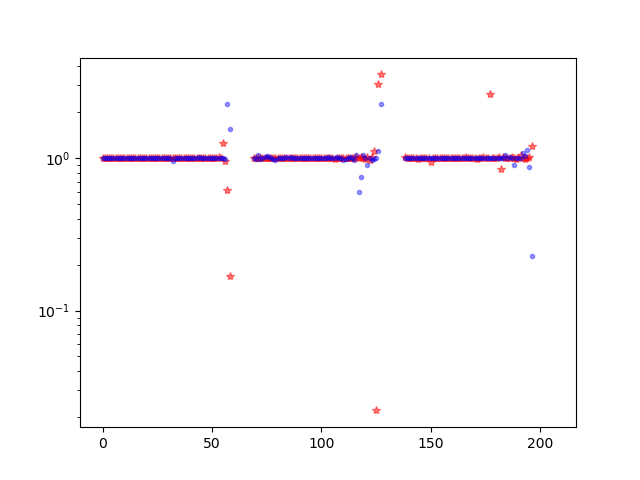

In [53]:
plt.figure()
plt.semilogy(abs(uop.real/uop2.real), '*r', alpha=0.5)
plt.semilogy(abs(uop.imag/uop2.imag), '.b', alpha=0.4)
plt.show()

In [26]:
plt.figure()

plt.subplot(331)
im = plt.imshow(ur.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_r$ - actual')
plt.subplot(332)
im = plt.imshow(urInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_r$ - Inverted')
plt.subplot(333)
im = plt.imshow(ur.real - urInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_r$ - Diff')

plt.subplot(334)
im = plt.imshow(ut.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_t$ - actual')
plt.subplot(335)
im = plt.imshow(utInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_t$ - Inverted')
plt.subplot(336)
im = plt.imshow(ut.real - utInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_t$ - Diff')

plt.subplot(337)
im = plt.imshow(up.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_p$ - actual')
plt.subplot(338)
im = plt.imshow(upInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_p$ - Inverted')
plt.subplot(339)
im = plt.imshow(up.real - upInv.real, cmap='seismic')
plt.colorbar(im)
plt.title('$u_p$ - Diff')

plt.tight_layout()
plt.show()

plt.figure()
uipmag = np.sqrt(abs(ur)**2 + abs(ut)**2 + abs(up)**2)
uInvmag = np.sqrt(abs(urInv)**2 + abs(utInv)**2 + abs(upInv)**2)
plt.subplot(131)
im = plt.imshow(uipmag, cmap='seismic')
plt.colorbar(im)
plt.title('$|u|$ - actual')
plt.subplot(132)
im = plt.imshow(uInvmag, cmap='seismic')
plt.colorbar(im)
plt.title('$|u|$ - Inverted')
plt.subplot(133)
im = plt.imshow(uipmag - uInvmag, cmap='seismic')
plt.colorbar(im)
plt.title('$|u|$ - Diff')

plt.tight_layout()
plt.show()

#theta = np.linspace(1e-5, pi - 1e-5, 2*thSize)
lr = np.cos(theta); lt = -np.sin(theta)
ipVelLOS = ur[:thSize, :]*lr.reshape(thSize, 1) + ut[:thSize, :]*lt.reshape(thSize, 1)
invVelLOS = urInv[:thSize, :]*lr.reshape(thSize, 1) + utInv[:thSize, :]*lt.reshape(thSize, 1)

maxVel = max( ipVelLOS.real.max(), invVelLOS.real.max() )
minVel = max( ipVelLOS.real.min(), invVelLOS.real.min() )
bigMax = max( abs(maxVel), abs(minVel) )

plt.figure()
plt.subplot(221)
im = plt.imshow(ipVelLOS.real, vmax=bigMax, vmin=-bigMax, cmap='seismic')
plt.colorbar(im)
plt.title('input')

plt.subplot(222)
im = plt.imshow(invVelLOS.real, vmax=bigMax, vmin=-bigMax, cmap='seismic')
plt.colorbar(im)
plt.title('inverted')

plt.subplot(223)
im = plt.imshow( invVelLOS.real - ipVelLOS.real, vmax=bigMax, vmin=-bigMax, cmap='seismic')
plt.colorbar(im)
plt.title('diff')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

NameError: name 'ur' is not defined

In [ ]:
plt.figure()
im = plt.imshow(invVelLOS.real - ipVelLOS.real, cmap='seismic')
plt.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


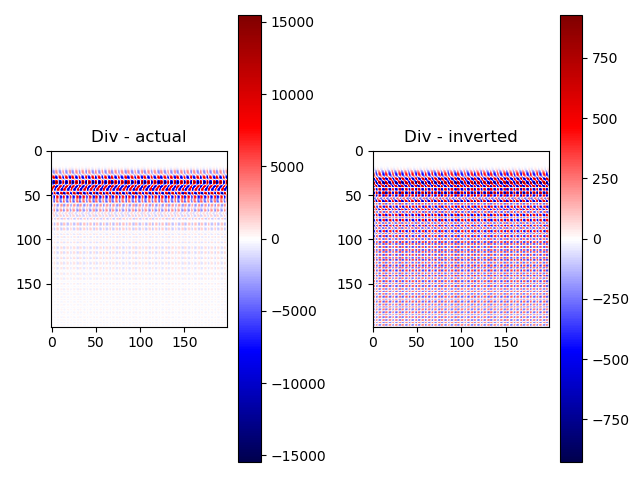

In [36]:
diver = hor_div(ut[:thSize, :].real, up[:thSize, :].real, theta, phi)
diverInv = hor_div(utInv[:thSize, :].real, upInv[:thSize, :].real, theta, phi)
plt.figure()
plt.subplot(121)
im = plt.imshow(diver, cmap='seismic')
plt.colorbar(im)
plt.title('Div - actual')

plt.subplot(122)
im = plt.imshow(diverInv, cmap='seismic')
plt.colorbar(im)
plt.title('Div - inverted')

plt.tight_layout()
plt.show()

In [ ]:
powerSpec.shape